# data

Load OHLC data from cryptocurrency exchange Poloniex

In [1]:
from vectorbt import data, graphics
from datetime import datetime
from importlib import reload
import pytz
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 5)

In [2]:
ohlc_df = data.load_cryptopair('USDT_BTC', data.ago_dt(days=30), data.now_dt())
ohlc_df.head()

done. 1.15s


,O,H,L,C,V
date,,,,,
2017-10-22 13:10:00,5851.000000,5852.000000,5850.0,5850.000000,19361.578781
2017-10-22 13:15:00,5850.000000,5853.732454,5821.0,5821.000000,199229.252660
2017-10-22 13:20:00,5821.000000,5845.339999,5820.0,5828.000000,24898.828840
2017-10-22 13:25:00,5828.000000,5833.127086,5828.0,5832.476775,43757.054498
2017-10-22 13:30:00,5832.476775,5845.340000,5830.0,5845.340000,26807.358037


In [3]:
rate_sr = ohlc_df['O']

    count         mean         std      min     25%         50%       75%  \
O  8640.0  6739.154958  773.611132  5302.64  5980.0  6774.46218  7336.065   

      max  
O  8299.0  


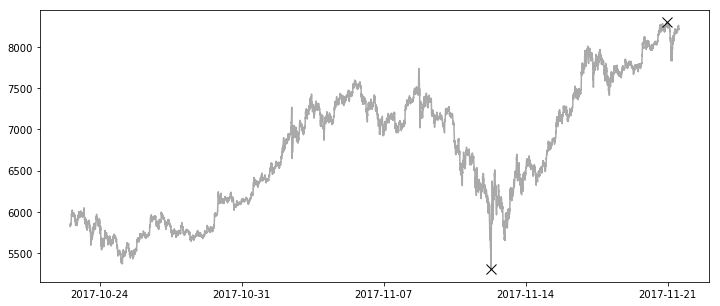

In [4]:
graphics.plot_line(rate_sr)

## indicators

Calculate simple moving averages

In [5]:
from vectorbt import indicators

In [6]:
fast_ma_sr = indicators.EMA(rate_sr, 50)
slow_ma_sr = indicators.EMA(rate_sr, 100)

Calculate upper and lower Bollinger Bands

In [7]:
upper_band_sr, lower_band_sr = indicators.BB(rate_sr, 20, 3)

# signals

In [8]:
from vectorbt import signals
import numpy as np

First condition: Go long whenever fast SMA is over slow SMA, while go short when opposite occurs

In [9]:
ma_evector = signals.DMAC_evector(fast_ma_sr, slow_ma_sr)
ma_xvector = signals.DMAC_xvector(fast_ma_sr, slow_ma_sr)

Second condition: Go long/short when outside of Bollinger Bands

In [10]:
bb_evector = signals.BB_evector(rate_sr, lower_band_sr)
bb_xvector = signals.BB_xvector(rate_sr, upper_band_sr)

# vector

Both, entry and exit vectors, are sequences of 0 and 1 (bit-vectors) to allow fast vector operations

In [11]:
from vectorbt import vector

Combining vectors is easy using `vector.AND/OR/XOR` operations

In [12]:
evector = vector.AND(ma_evector, bb_evector)
xvector = vector.AND(ma_xvector, bb_xvector)

We reduce both vectors to contain only signals that are first in their sequences. This way, we get neither outdated signals, nor typical issues like entry immediatelly after exit or vice versa.

In [13]:
evector = vector.first(evector)
xvector = vector.first(xvector)

# positions

In [14]:
from vectorbt import positions

Generete positions out of both vectors (merge and reduce)

In [15]:
pos_sr = positions.from_vectors(rate_sr, evector, xvector)
pos_sr.head()

date
2017-10-24 19:00:00    1
2017-10-28 00:10:00   -1
2017-10-30 14:25:00    1
2017-11-04 12:40:00   -1
2017-11-04 22:35:00    1
dtype: int64

Position series has always even number of positions. First position is always long, the last one always short. This kind of fixed structure (`[0::2]` for long, `[1::2]` for short) makes further manipulations, such as calculation of equity, very easy.

Visualize entries and exits

   count        mean         std  min         25%        50%        75%  \
O    6.0  426.606394  440.409084  0.0  158.041954  223.84636  739.84046   

      max  
O  1064.0  


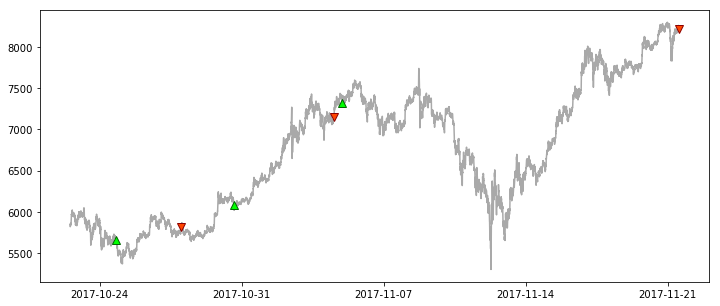

In [16]:
positions.plot(rate_sr, pos_sr)

# returns

In [18]:
from vectorbt import returns

Generate % returns out of positions. Takes into account fees.

In [19]:
posret_sr = returns.from_positions(rate_sr, pos_sr, 0.0025)
posret_sr.head()

date
2017-10-24 19:00:00   -0.002500
2017-10-28 00:10:00    0.024467
2017-10-30 14:25:00   -0.002500
2017-11-04 12:40:00    0.171833
2017-11-04 22:35:00   -0.002500
dtype: float64

Position returns series (`posret`) inherits the structure of the position series and make them redundant. Because we apply fees, we get negative returns on long. If fees are zero, returns on long are also zero, but still included in the series. 

Generate hold returns.

In [20]:
returns.on_hold(rate_sr, 0.0015)

date
2017-10-22 13:10:00   -0.001500
2017-11-21 13:05:00    0.402781
dtype: float64

   count      mean       std     min     25%       50%       75%       max
0    6.0  0.051361  0.075584 -0.0025 -0.0025  0.010984  0.095642  0.171833


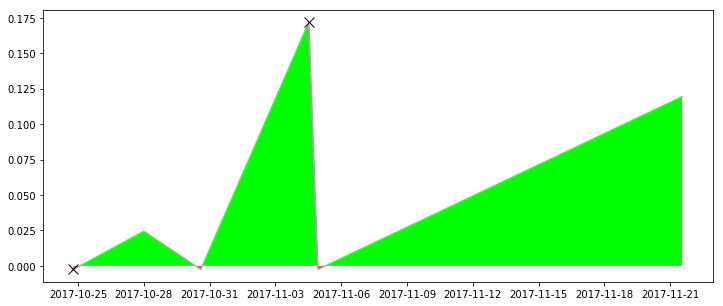

In [21]:
returns.plot(posret_sr)

# equity

In [22]:
from vectorbt import equity

Generate equity in base and quote currency from position returns

In [23]:
equity_df = equity.from_returns(rate_sr, posret_sr)
equity_df.head()

,base,quote
date,,
2017-10-22 13:10:00,NaN,NaN
2017-10-22 13:15:00,NaN,NaN
2017-10-22 13:20:00,NaN,NaN
2017-10-22 13:25:00,NaN,NaN
2017-10-22 13:30:00,NaN,NaN


Base and quote are NaN before the first entry or if no positions were taken

Visualize both equities

base
    count        mean         std         min         25%         50%  \
0  7994.0 -422.767237  219.431657 -676.141888 -583.616956 -518.386122   

          75%         max  
0 -338.844994  141.359384  


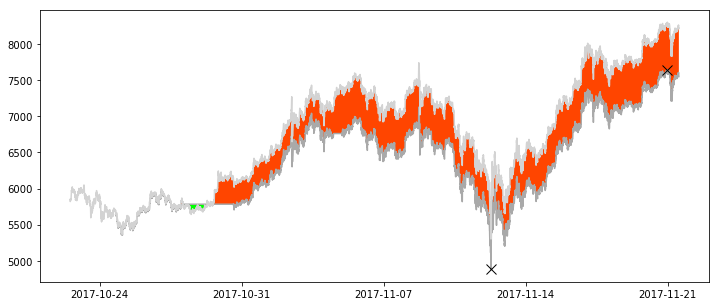

quote
    count      mean       std      min       25%       50%       75%      max
0  7994.0 -0.059646  0.029868 -0.09091 -0.079266 -0.079266 -0.052251  0.02505


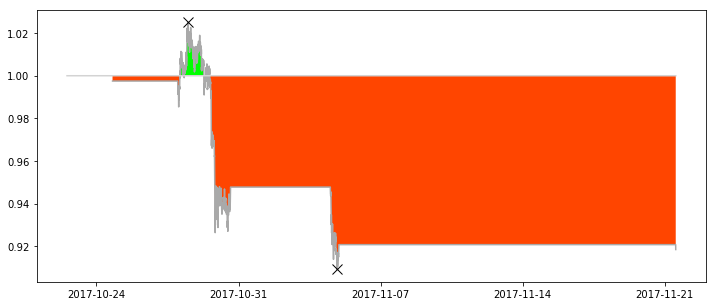

In [24]:
equity.plot(rate_sr, equity_df)

Equity diffs (`eqd`) are absolute returns if initial investment was 1. They are used in calculation of performance and risk/profit indicators such as sharpe ratio.

In [25]:
eqd_sr = equity.diffs(posret_sr)
eqd_sr.head()

date
2017-10-28 00:10:00    0.024406
2017-11-04 12:40:00    0.175158
2017-11-21 13:05:00    0.142228
dtype: float64

# kpi

In [26]:
from vectorbt import kpi

Print summary of multiple KPIs applied on equity diffs

In [27]:
kpi.print_summary(eqd_sr)

{
  "performance": {
    "profit": 0.3417923319566163,
    "averages": {
      "trade": 0.11393077731887209,
      "gain": 0.11393077731887209,
      "loss": NaN
    },
    "winrate": 1.0,
    "payoff": NaN,
    "PF": NaN,
    "RF": NaN
  },
  "risk/return profile": {
    "sharpe": 1.4374389323982426,
    "sortino": NaN,
    "maxdd": 0.0
  }
}


# optimizer.gridsearch

The classic optimization method is grid search (or exhaustive search). It exhaustively generates candidates from a grid of parameter values and applies them on the series. 

This method brings some advantages:
- its simple to implement
- 2d-combinations can be visualized using heatmaps
- can be used to discover hidden patterns in combinations
- highly parallelizable

But also drawbacks are possible:
- not flexible enough to fit changing financial markets
- prone to overfitting
- no intermediate feedback

**Grid search consists of 4 levels:**

| Level | Motivation | Module |
|-|-|-|-|
| 1 | Calculate equity diffs | `seriesmap` |
| 2 | Calculate KPIs on equity diffs and compare | `nummap` |
| 3 | Combine multiple KPIs into a single score and compare | `scoremap` |
| 4 | Find patterns by building a heatmap | `matrix` |

At the end we will be able to compare performance of different trading strategies

## L1
## seriesmap

In [137]:
from vectorbt.optimizer.gridsearch import params, seriesmap, mapper

Calculate equity diffs for a range of EMA combinations

    1. Precalculate all EMAs

In [115]:
# Init
ma_func = lambda window: indicators.EMA(rate_sr, window)
min_ma, max_ma, step = 1, 100, 1
fees = 0.0025

# Cache moving averages
param_range = params.range_params(min_ma, max_ma, step)
mamap = seriesmap.from_func(ma_func, param_range)

cores: 4
processes: 3
starmap: False
calcs: 100 ..
done. 0.23s


    2. For each EMA combination, generate respective equity diffs

In [117]:
# Func
def ma_eqdfunc(fast_ma, slow_ma):
    # Requires multiple layers of calculations
    fast_ma_sr = mamap[fast_ma]
    slow_ma_sr = mamap[slow_ma]
    entries = signals.DMAC_evector(fast_ma_sr, slow_ma_sr)
    exits = signals.DMAC_xvector(fast_ma_sr, slow_ma_sr)
    pos_sr = positions.from_vectors(rate_sr, entries, exits)
    posret_sr = returns.from_positions(rate_sr, pos_sr, fees)
    eqd_sr = equity.diffs(posret_sr)
    return eqd_sr

# Params
param_space = params.combine_rep_params(min_ma, max_ma, step, 2)

In [145]:
ma_eqdmap = seriesmap.from_func(ma_eqdfunc, param_space)

cores: 4
processes: 3
starmap: True
calcs: 5050 ..
done. 14.09s


Generate equity diffs for random positions. Number of positions is the same as for EMA, to be comparable.

In [154]:
# Func
def random_eqdfunc(n):
    entries = signals.random_vector(rate_sr, n)
    exits = signals.random_vector(rate_sr, n, evector=entries)
    pos_sr = positions.from_vectors(rate_sr, entries, exits)
    posret_sr = returns.from_positions(rate_sr, pos_sr, fees)
    eqd_sr = equity.diffs(posret_sr)
    return eqd_sr

# Params
param_range = np.array(mapper.map(lambda sr: len(sr.index), list(ma_eqdmap.values())))+1

cores: 4
processes: 3
starmap: False
calcs: 5050 ..
done. 2.91s


In [156]:
random_eqdmap = seriesmap.from_func(random_eqdfunc, param_range)

cores: 4
processes: 3
starmap: False
calcs: 5050 ..
done. 12.06s


## L2
## nummap

Apply KPI on each equity diffs series

In [173]:
from vectorbt.optimizer.gridsearch import nummap

In [174]:
ma_exp_sr = nummap.from_seriesmap(ma_eqdmap, kpi.expectancy)

cores: 4
processes: 3
starmap: False
calcs: 5050 ..
done. 2.83s
min (18, 85): -0.00226369110764
max (55, 62): 0.00602637022216


In [175]:
ma_sharpe_sr = nummap.from_seriesmap(ma_eqdmap, kpi.sharpe)

cores: 4
processes: 3
starmap: False
calcs: 5050 ..
done. 3.03s
min (1, 19): -0.34324236838
max (55, 62): 0.204821934948


In [176]:
random_exp_sr = nummap.from_seriesmap(random_eqdmap, kpi.expectancy)

cores: 4
processes: 3
starmap: False
calcs: 416 ..
done. 0.37s
min 50: -0.00743256947188
max 28: 0.0210298368385


Compare quantile distributions of EMA and random strategy KPIs

    count      mean       std       min       25%       50%       75%  \
0   416.0  0.000056  0.002897 -0.007433 -0.001295 -0.000819  0.000369   
1  4950.0  0.000698  0.002422 -0.002264 -0.001473 -0.000454  0.003033   

        max  
0  0.021030  
1  0.006026  


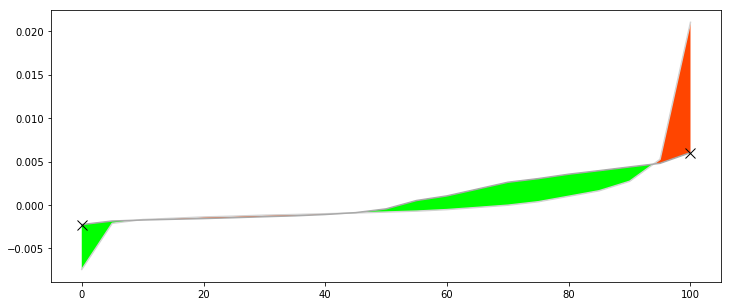

In [162]:
nummap.compare(random_exp_sr, ma_exp_sr)

## L3
## scoremap

Take into account multiple weighted KPIs and generate a score from 1 to 100

In [170]:
from vectorbt.optimizer.gridsearch import scoremap

In [171]:
ma_scoremap_sr = scoremap.from_nummaps([ma_exp_sr, ma_sharpe_sr], [2/3, 1/3], [False, False])

done. 0.01s
min (1, 1): 1.0
max (55, 62): 100.0


## L4
## matrix

Reshape 2d-parameter grid into a matrix and display as a heatmap

In [180]:
from vectorbt.optimizer.gridsearch import matrix
from matplotlib import pyplot as plt
import pandas as pd

In [182]:
ma_matrix_df = matrix.from_nummap(ma_exp_sr, symmetric=True).fillna(0)

done. 1.58s


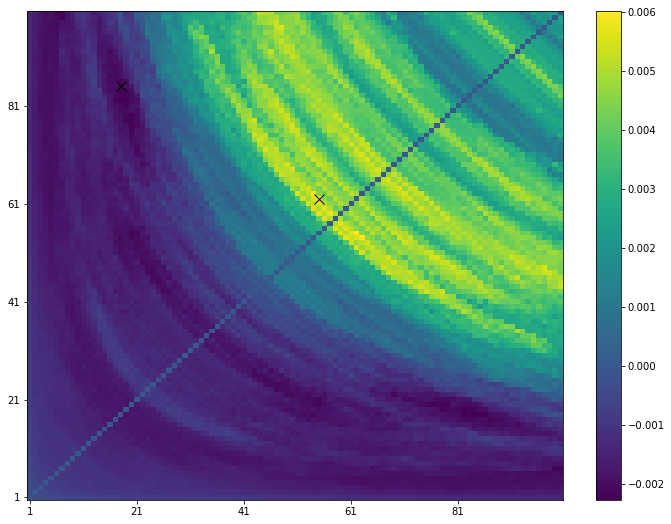

In [183]:
cmap = plt.cm.viridis
norm = plt.Normalize()
matplotlib.rcParams['figure.figsize'] = (12, 9)
matrix.plot(ma_matrix_df, cmap, norm)

Compare KPI distribution to that of random map

    count      mean       std       min       25%       50%       75%  \
0  4950.0  0.000698  0.002422 -0.002264 -0.001473 -0.000454  0.003033   

        max  
0  0.006026  


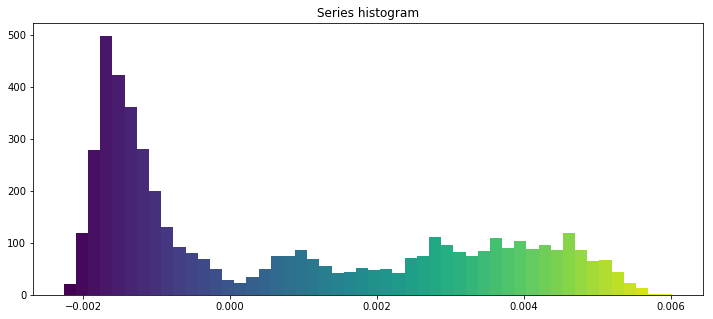

In [184]:
matplotlib.rcParams['figure.figsize'] = (12, 5)
graphics.plot_hist(ma_exp_sr.dropna(), cmap, norm)

   count      mean       std       min       25%       50%      75%      max
0  418.0  0.000065  0.002907 -0.007433 -0.001296 -0.000819  0.00037  0.02103


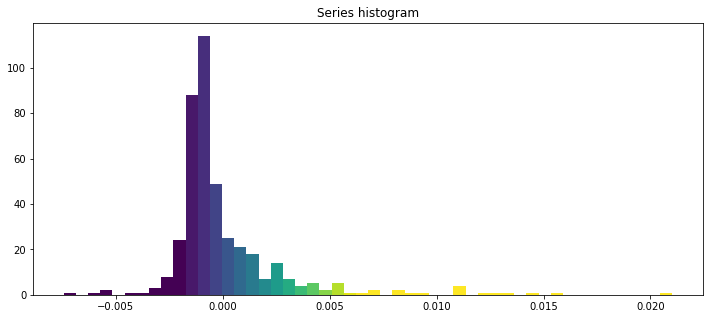

In [185]:
# Adjust bounds
to_plot = random_exp_sr.append(pd.Series(ma_exp_sr.min())).append(pd.Series(ma_exp_sr.max()))
graphics.plot_hist(to_plot, cmap, norm)